# Object

* 데이터의 분포를 살펴본다. 
* 데이터 간의 관계를 살펴본다. 

## Import Library

In [1]:
# opencv importerror
# !$sudo apt-get install -y libgl1-mesa-glx

In [2]:
import os
from tqdm.notebook import tqdm

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.image as img
import seaborn as sns
from PIL import Image
import cv2

import warnings

In [3]:
warnings.filterwarnings('ignore')

tqdm.pandas()

%matplotlib inline

In [4]:
TRAIN_DATA_PATH = '../../input/data/train/train.csv'
TRAIN_IMG_PATH = '../../input/data/train/images'
SUBMISSION_PATH = '../../input/data/eval/info.csv'
EVAL_IMG_PATH = '../../input/data/eval/images'

# EDA

## Data Loading and Check

In [5]:
# 데이터 가져오기
train_data = pd.read_csv(TRAIN_DATA_PATH)
train_data

id  gender   race  age                    path
0     000001  female  Asian   45  000001_female_Asian_45
1     000002  female  Asian   52  000002_female_Asian_52
2     000004    male  Asian   54    000004_male_Asian_54
3     000005  female  Asian   58  000005_female_Asian_58
4     000006  female  Asian   59  000006_female_Asian_59
...      ...     ...    ...  ...                     ...
2695  006954    male  Asian   19    006954_male_Asian_19
2696  006955    male  Asian   19    006955_male_Asian_19
2697  006956    male  Asian   19    006956_male_Asian_19
2698  006957    male  Asian   20    006957_male_Asian_20
2699  006959    male  Asian   19    006959_male_Asian_19

[2700 rows x 5 columns]

In [6]:
# 통계적 수치 살펴보기
train_data.describe()

age
count  2700.000000
mean     37.708148
std      16.985904
min      18.000000
25%      20.000000
50%      36.000000
75%      55.000000
max      60.000000

In [7]:
# 데이터 정보 살펴보기
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2700 entries, 0 to 2699
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2700 non-null   object
 1   gender  2700 non-null   object
 2   race    2700 non-null   object
 3   age     2700 non-null   int64 
 4   path    2700 non-null   object
dtypes: int64(1), object(4)
memory usage: 105.6+ KB


## Basic EDA

마스크를 착용하는 건 COIVD-19의 확산을 방지하는데 중요한 역할을 합니다. 제공되는 이 데이터셋은 사람이 마스크를 착용하였는지 판별하는 모델을 학습할 수 있게 해줍니다. 모든 데이터셋은 아시아인 남녀로 구성되어 있고 나이는 20대부터 70대까지 다양하게 분포하고 있습니다. 간략한 통계는 다음과 같습니다.

전체 사람 명 수 : 4,500

한 사람당 사진의 개수: 7 [마스크 착용 5장, 이상하게 착용(코스크, 턱스크) 1장, 미착용 1장]

이미지 크기: (384, 512)

전체 데이터셋 중에서 60%는 학습 데이터셋으로 활용됩니다.

입력값. 마스크 착용 사진, 미착용 사진, 혹은 이상하게 착용한 사진(코스크, 턱스크)

예시:

결과값. 총 18개의 class를 예측해야합니다. 결과값으로 0~17에 해당되는 숫자가 각 이미지 당 하나씩 나와야합니다.

예시:

7 (the class of cfe1268.jpg)

2 (the class of 3a2662c.jpg)

...

![class description](https://s3-ap-northeast-2.amazonaws.com/aistages-public-junyeop/app/Users/00000025/files/56bd7d05-4eb8-4e3e-884d-18bd74dc4864..png)

In [8]:
# 각 피쳐 별 고유값 살펴보기
for category in train_data.columns:
    print(f'"{category}" feature has {len(train_data[category].unique())} unique values: {train_data[category].unique()}')

"id" feature has 2699 unique values: ['000001' '000002' '000004' ... '006956' '006957' '006959']
"gender" feature has 2 unique values: ['female' 'male']
"race" feature has 1 unique values: ['Asian']
"age" feature has 43 unique values: [45 52 54 58 59 56 57 55 50 49 53 51 40 25 48 29 35 37 19 42 24 23 30 18
 22 26 21 27 60 20 28 44 34 39 43 33 41 47 46 36 38 32 31]
"path" feature has 2700 unique values: ['000001_female_Asian_45' '000002_female_Asian_52' '000004_male_Asian_54'
 ... '006956_male_Asian_19' '006957_male_Asian_20' '006959_male_Asian_19']


In [9]:
# "id" 피쳐에서 겹치는 값 찾기
train_data.duplicated(["id"])[lambda x:x]
print(train_data.iloc[1367])
print(train_data[train_data["id"]=="003397"])

id                        003397
gender                    female
race                       Asian
age                           19
path      003397_female_Asian_19
Name: 1367, dtype: object
          id  gender   race  age                    path
1366  003397  female  Asian   20  003397_female_Asian_20
1367  003397  female  Asian   19  003397_female_Asian_19


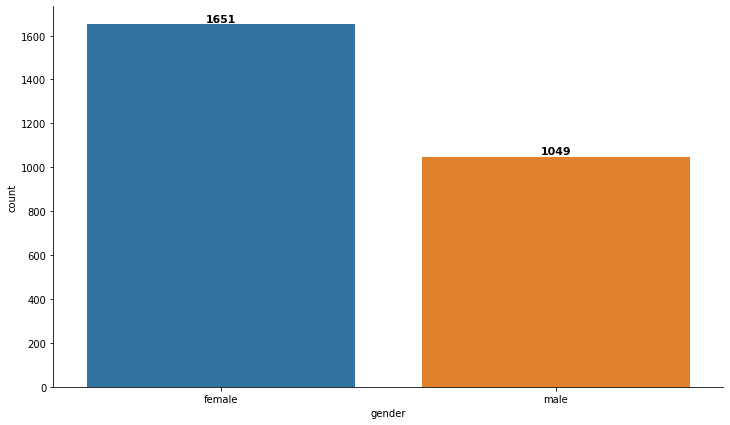

In [10]:
# gender 피쳐 분포 보기
fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot(111)

sns.countplot(x='gender', data=train_data, 
    order=sorted(train_data['gender'].unique()), 
    ax=ax
    )

for idx, val in enumerate(train_data['gender'].sort_index().value_counts()):
    ax.text(x=idx, y=val+3, s=val, 
        va='bottom', ha='center', 
        fontsize=11, fontweight='semibold')

for s in ['top', 'right']:
    ax.spines[s].set_visible(False)



plt.show()

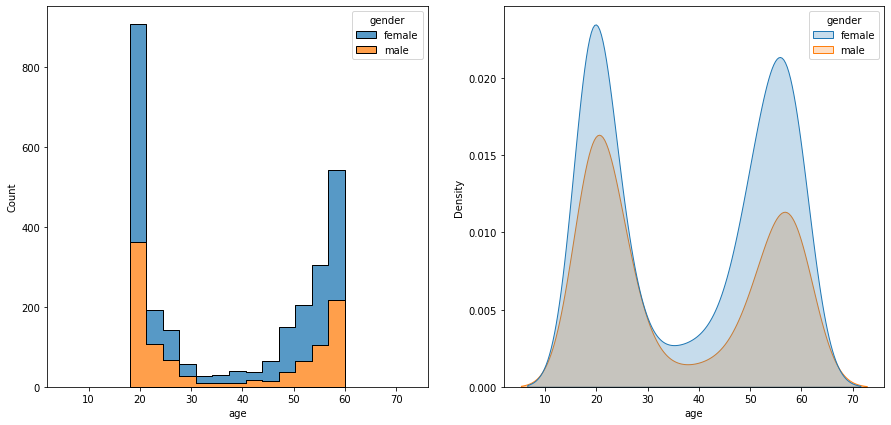

In [11]:
# age 피쳐 분포 보기
fig, axes = plt.subplots(1,2,figsize=(15,7), sharex=True)

sns.histplot(x='age', data=train_data, ax=axes[0], 
    hue='gender',
    element='step', 
    multiple='stack')
sns.kdeplot(x='age', data=train_data, ax=axes[1], 
    hue='gender', 
    fill=True, 
    multiple="layer", 
    cumulative=False)

plt.show()

In [12]:
print(min(train_data['age']))
print(max(train_data['age']))

18
60


In [13]:
# 나이의 범위를 나타내는 피쳐 추가
age_range = []
for i in range(len(train_data)):
    age = train_data.iloc[i]['age']
    if age < 30: _age = '< 30'
    elif age < 60: _age = '>= 30 and < 60'
    else: _age = '>= 60'
    age_range.append(_age)

train_data_with_agerange = train_data
train_data_with_agerange['age_range'] = age_range
train_data_with_agerange

id  gender   race  age                    path       age_range
0     000001  female  Asian   45  000001_female_Asian_45  >= 30 and < 60
1     000002  female  Asian   52  000002_female_Asian_52  >= 30 and < 60
2     000004    male  Asian   54    000004_male_Asian_54  >= 30 and < 60
3     000005  female  Asian   58  000005_female_Asian_58  >= 30 and < 60
4     000006  female  Asian   59  000006_female_Asian_59  >= 30 and < 60
...      ...     ...    ...  ...                     ...             ...
2695  006954    male  Asian   19    006954_male_Asian_19            < 30
2696  006955    male  Asian   19    006955_male_Asian_19            < 30
2697  006956    male  Asian   19    006956_male_Asian_19            < 30
2698  006957    male  Asian   20    006957_male_Asian_20            < 30
2699  006959    male  Asian   19    006959_male_Asian_19            < 30

[2700 rows x 6 columns]

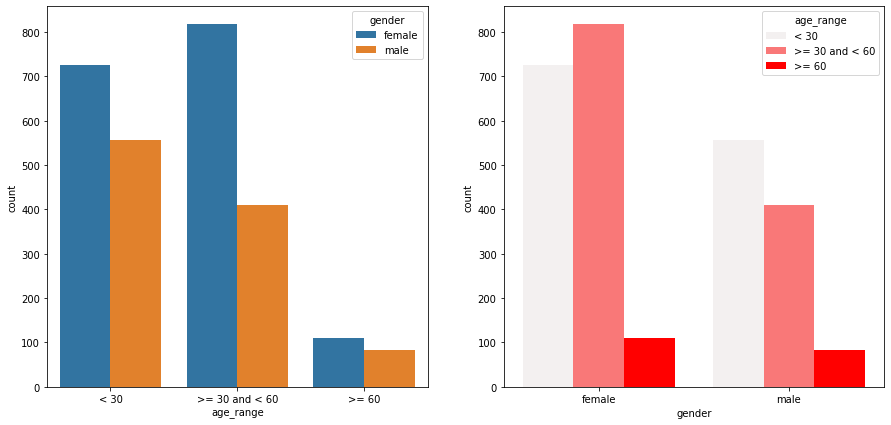

In [14]:
# gender-age 간 분포
fig, axes = plt.subplots(1, 2, figsize=(15,7))

sns.countplot(x='age_range',
    data=train_data_with_agerange, 
    order=sorted(train_data_with_agerange['age_range'].unique()),
    hue='gender', 
    ax=axes[0])

sns.countplot(x='gender', data=train_data_with_agerange, 
    order=sorted(train_data['gender'].unique()), 
    hue='age_range', 
    hue_order=sorted(train_data['age_range'].unique()), 
    color='red', 
    saturation=1, 
    ax=axes[1])

plt.show()

## Check Images

이미지는 각 사람 당 7개가 있고, 올바른 착용 5개 이상한 착용 1개 미착용 1개의 이미지가 있다. 

In [15]:
# 이미지 분포 확인
def get_img_list(path):
    img_list = os.listdir(TRAIN_IMG_PATH+'/'+path) # 데이터+이미지 총 14개
    ret = [img for img in img_list if '._' not in img] # 이미지 데이터만 가져옴
    return ret

train_data['img_count'] = train_data['path'].apply(lambda x:len(get_img_list(x)))
train_data.describe()

age  img_count
count  2700.000000     2700.0
mean     37.708148        7.0
std      16.985904        0.0
min      18.000000        7.0
25%      20.000000        7.0
50%      36.000000        7.0
75%      55.000000        7.0
max      60.000000        7.0

../../input/data/train/images/000592_female_Asian_57/incorrect_mask.jpg
[[[166 153  67]
  [165 152  66]
  [164 150  67]
  ...
  [182 190 183]
  [183 191 184]
  [184 192 185]]

 [[167 154  68]
  [166 153  67]
  [165 151  68]
  ...
  [182 190 183]
  [183 191 184]
  [184 192 185]]

 [[169 155  72]
  [168 154  71]
  [167 153  71]
  ...
  [183 191 184]
  [184 192 185]
  [184 192 185]]

 ...

 [[ 31  29 135]
  [ 28  26 132]
  [ 32  30 136]
  ...
  [ 65  60 175]
  [ 68  63 178]
  [ 67  63 176]]

 [[ 30  28 134]
  [ 30  28 134]
  [ 36  34 140]
  ...
  [ 65  60 175]
  [ 69  64 179]
  [ 66  61 176]]

 [[ 30  28 134]
  [ 30  28 134]
  [ 38  36 142]
  ...
  [ 66  60 177]
  [ 69  64 179]
  [ 65  60 175]]]
../../input/data/train/images/000592_female_Asian_57/mask1.jpg
[[[136 120  53]
  [136 120  53]
  [139 122  59]
  ...
  [144 153 150]
  [144 153 150]
  [144 153 150]]

 [[136 120  53]
  [135 119  52]
  [137 120  57]
  ...
  [145 154 151]
  [144 153 150]
  [144 153 150]]

 [[136 120  53]
  [134 118 

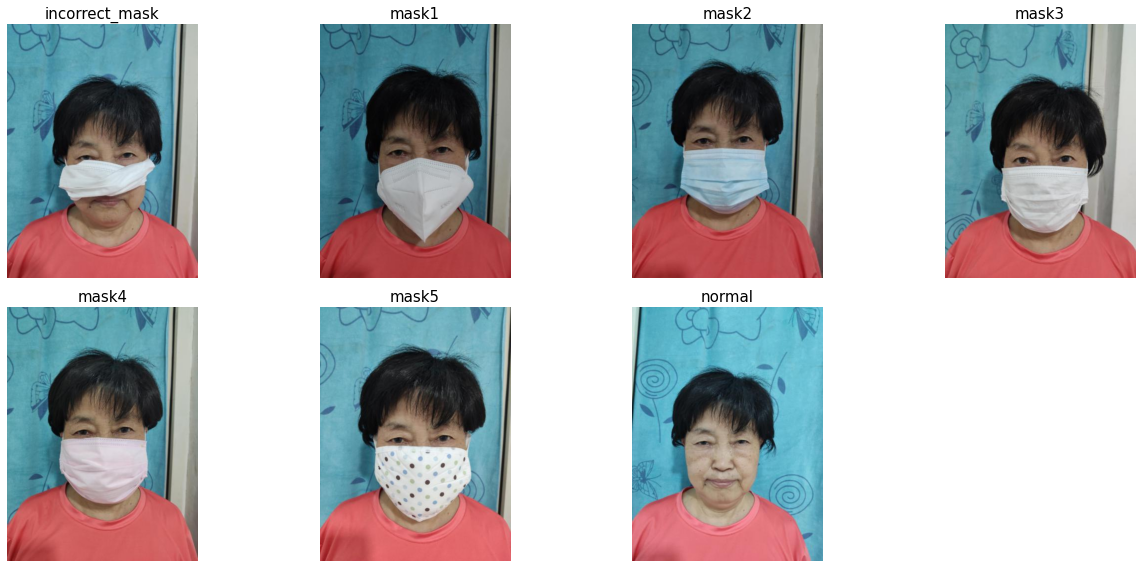

In [16]:
# 이미지 보기
# sampling
sample = train_data.sample()

# sampling된 사람의 7개 사진의 경로 가져오기
sample_img_path = sample.path.values[0] # values: value, dtype
sample_img_list = [img for img in os.listdir(TRAIN_IMG_PATH+'/'+sample_img_path) if '._' not in img]
sample_img_list = sorted(sample_img_list)

# 이미지 출력
fig = plt.figure(figsize=(18,8))

for i, filename in enumerate(sample_img_list):
    img_path = os.path.join(TRAIN_IMG_PATH, sample_img_path, filename)
    print(img_path)
    img = cv2.imread(img_path)
    print(img)
    ax = fig.add_subplot(2, 4, i+1)
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax.axis('off')
    ax.set_title(filename.split('.')[0], fontsize=15)

plt.tight_layout()
plt.show()

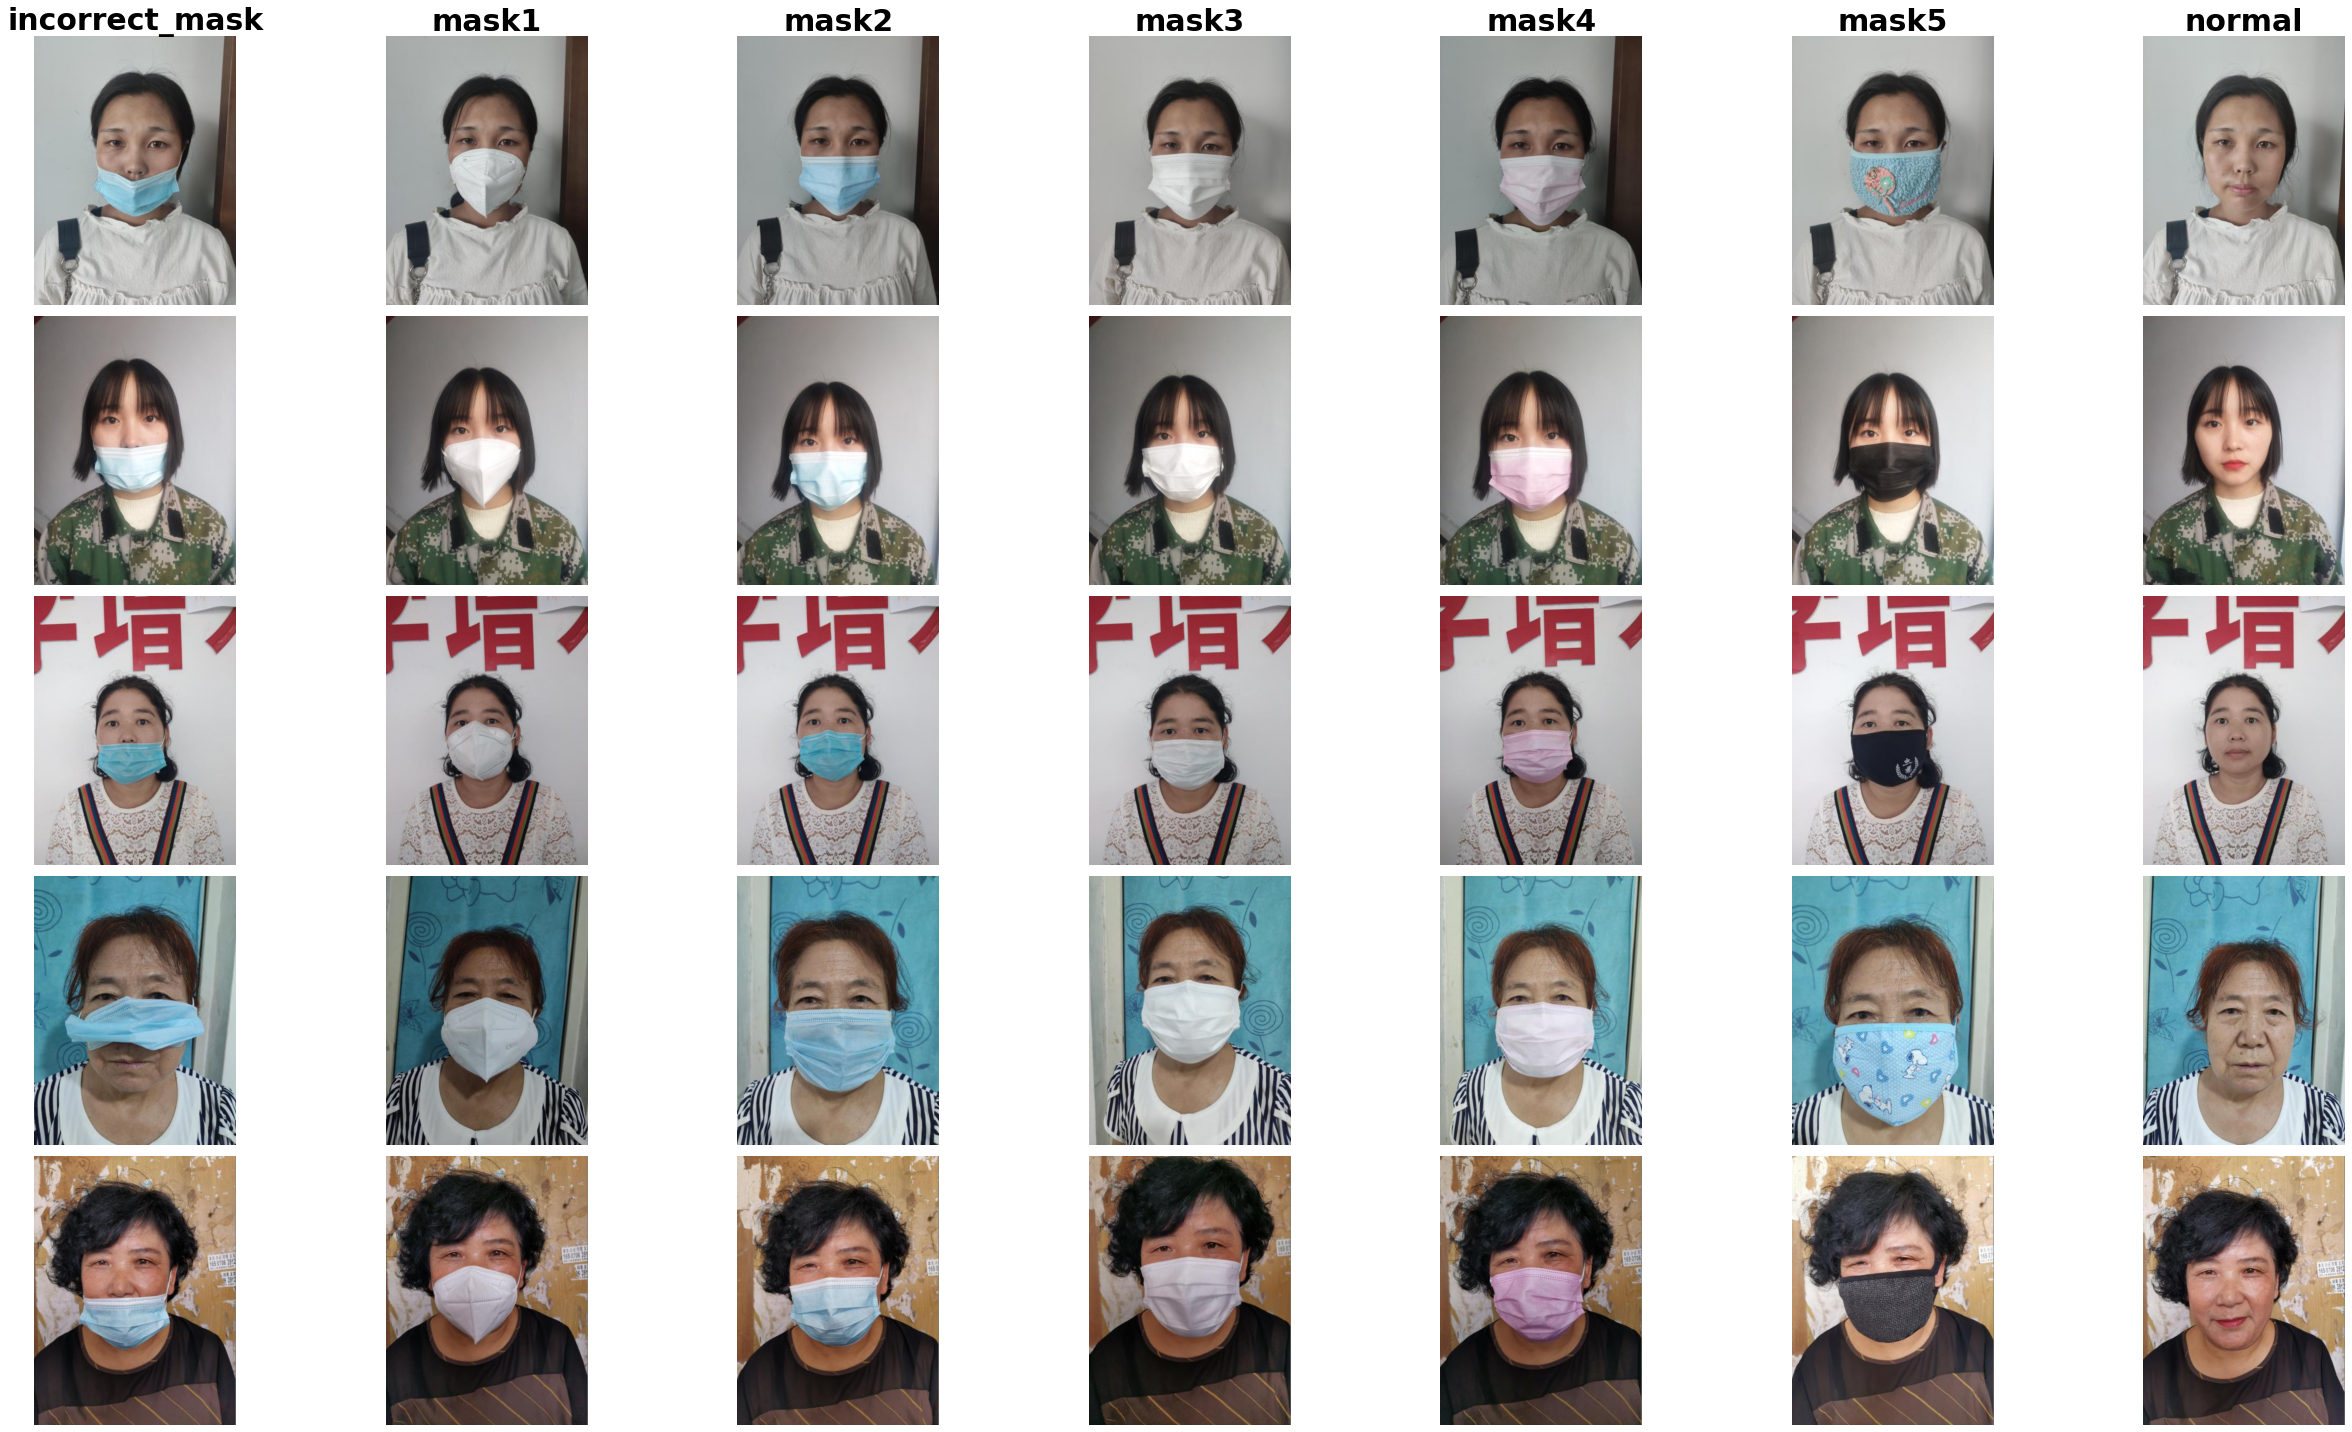

In [17]:
# 5개 샘플에 대해 이미지 출력
sample = train_data.sample(5)
sample_img_path = sample.path.values
img_list = []

for img in sample_img_path:
    lists = []
    imgs = [img for img in os.listdir(TRAIN_IMG_PATH+'/'+img) if '._' not in img]
    
    for data in imgs:
        path = TRAIN_IMG_PATH+'/'+img+'/'+data
        img_kind = data.split('.')[0]
        lists.append(path)
    lists = sorted(lists)
    img_list.append(lists)

fig = plt.figure(figsize=(35, 20))

i=1

for files in img_list:
    for filename in files:
        img = cv2.imread(filename)
        # print(img)
        # break
        ax = fig.add_subplot(5, 7, i)
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax.axis('off')
        
        if i < 8:
            ax.set_title(filename.split('/')[-1].split('.')[0], fontsize=30, fontdict={'weight':'semibold'})
        
        i += 1

plt.tight_layout()
plt.show()

# Conclusion

* 마스크 착용, 미착용, 비정상 착용의 클래스 불균형이 심하다
* id 003397을 가진 sample이 2개 있다. 
* female의 수가 male의 수보다 많다. 
* 60대 이상과 30~49세 사이 데이터가 매우 적다. 

# Appendix

신규범_T3116 캠퍼님의 코드를 참고하여 train.csv 파일을 데이터를 불러오기 쉬운 형태로 변환

In [18]:
from pathlib import Path

df = pd.DataFrame(None, columns = ['path', 'label'])
out_path = '~/input/data/train/customized_train.csv'

def age_group(x):
    if x < 30:
        return 0
    elif x < 60:
        return 1
    else:
        return 2

for index, line in enumerate(train_data.iloc):
    for file in list(os.listdir(os.path.join(TRAIN_IMG_PATH, line['path']))):
        if '._' in file:
            continue
        if file.split('.')[0] == 'normal':
            mask = 2
        elif file.split('.')[0] == 'incorrect_mask':
            mask = 1
        else:
            mask = 0
        gender = 0 if line['gender'] == 'male' else 1
        data = {
            'path': os.path.join(line['path'], file),
            'label': mask * 6 + gender * 3 + age_group(line['age'])
        }
        df = df.append(data, ignore_index=True)

df.to_csv(out_path)

In [19]:

# 각 라벨별 개수 확인, 커스텀된 csv 파일 확인
customized_train_data = pd.read_csv(out_path)
print('label \t count')
print(*[f'{label}:\t {count}' for (label,count) in zip(sorted(customized_train_data['label'].unique()), sorted(customized_train_data['label'].value_counts()))], sep='\n')
print('Total: ', sum(customized_train_data['label'].value_counts()))
customized_train_data.sample(20) # label: 0~17


label 	 count
0:	 83
1:	 83
2:	 109
3:	 109
4:	 410
5:	 410
6:	 415
7:	 545
8:	 556
9:	 556
10:	 725
11:	 725
12:	 817
13:	 817
14:	 2050
15:	 2780
16:	 3625
17:	 4085
Total:  18900


Unnamed: 0                                        path  label
3353         3353              001105_male_Asian_25/mask5.jpg      0
10472       10472            003569_female_Asian_60/mask5.jpg      5
12135       12135             004075_male_Asian_54/normal.jpg     13
3327         3327            001100_female_Asian_43/mask2.jpg      4
10803       10803              003676_male_Asian_58/mask2.jpg      1
18100       18100  006627_female_Asian_19/incorrect_mask.jpeg      9
10214       10214              003526_male_Asian_60/mask3.jpg      2
8728         8728            003234_female_Asian_20/mask4.jpg      3
11584       11584            003828_female_Asian_29/mask4.jpg      3
15199       15199            005457_female_Asian_36/mask2.jpg      4
3535         3535              001135_male_Asian_23/mask5.jpg      0
3930         3930              001190_male_Asian_24/mask1.jpg      0
17967       17967     006603_male_Asian_19/incorrect_mask.jpg      6
7523         7523   003004_female_Asian_19/incorrect_mask.jpg      9
7935         7935           003078_female_Asian_20/normal.jpg     15
18279       18279              006666_male_Asian_20/mask2.jpg      0
5761         5761              001564_male_Asian_22/mask5.jpg      0
7088         7088             001813_male_Asian_55/normal.jpg     13
2411         2411            000776_female_Asian_57/mask1.jpg      4
16311       16311            006175_female_Asian_18/mask1.png      3